In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from prophet import Prophet
from prophet.diagnostics import cross_validation

plt.style.use('ggplot')

In [28]:
df = pd.read_csv('sp500_index.csv')

In [29]:
df.tail()

,Date,S&P500
2512,2023-05-31,4179.83
2513,2023-06-01,4221.02
2514,2023-06-02,4282.37
2515,2023-06-05,4273.79
2516,2023-06-06,4283.85


In [30]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
df['Date'] = pd.to_datetime(df['Date'])

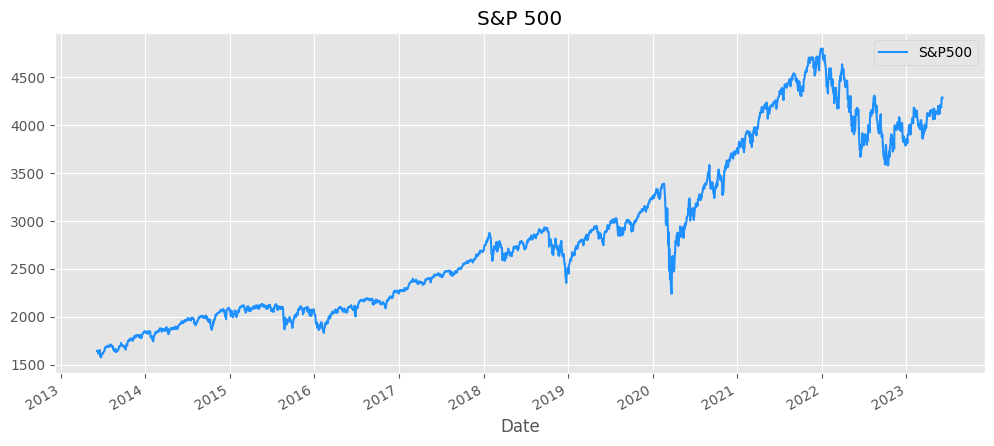

In [41]:
df.plot(style='-',
        figsize=(12,5),
        x='Date',
        y='S&P500',
        title='S&P 500',
        color='dodgerblue')
plt.show()

In [43]:
df_prophet = df.rename(columns={'Date':'ds',
                                'S&P500':'y'})

In [45]:
df_prophet.head()

,ds,y
0,2013-06-07,1643.38
1,2013-06-10,1642.81
2,2013-06-11,1626.13
3,2013-06-12,1612.52
4,2013-06-13,1636.36


In [64]:
%%time
model = Prophet(interval_width=0.95, weekly_seasonality=False)
model.add_country_holidays(country_name='US')
model.fit(df_prophet)

14:25:48 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 1.16 s


In [65]:
future = model.make_future_dataframe(periods=182, freq='B')
forecast = model.predict(future)

In [66]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2694,2024-02-09,3741.340312,3391.580726,4191.886954,3427.396092,4099.238415,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,46.022847,46.022847,46.022847,0.0,0.0,0.0,3787.363159
2695,2024-02-12,3739.195333,3451.268412,4184.020946,3422.931610,4097.777164,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,48.944086,48.944086,48.944086,0.0,0.0,0.0,3788.139420
2696,2024-02-13,3738.480340,3406.480179,4185.089686,3419.896591,4093.647316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,49.282633,49.282633,49.282633,0.0,0.0,0.0,3787.762973
2697,2024-02-14,3737.765347,3384.871058,4193.180628,3416.538680,4095.266442,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,49.242893,49.242893,49.242893,0.0,0.0,0.0,3787.008240
2698,2024-02-15,3737.050354,3396.036619,4216.595719,3411.272740,4096.885568,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,48.797620,48.797620,48.797620,0.0,0.0,0.0,3785.847975


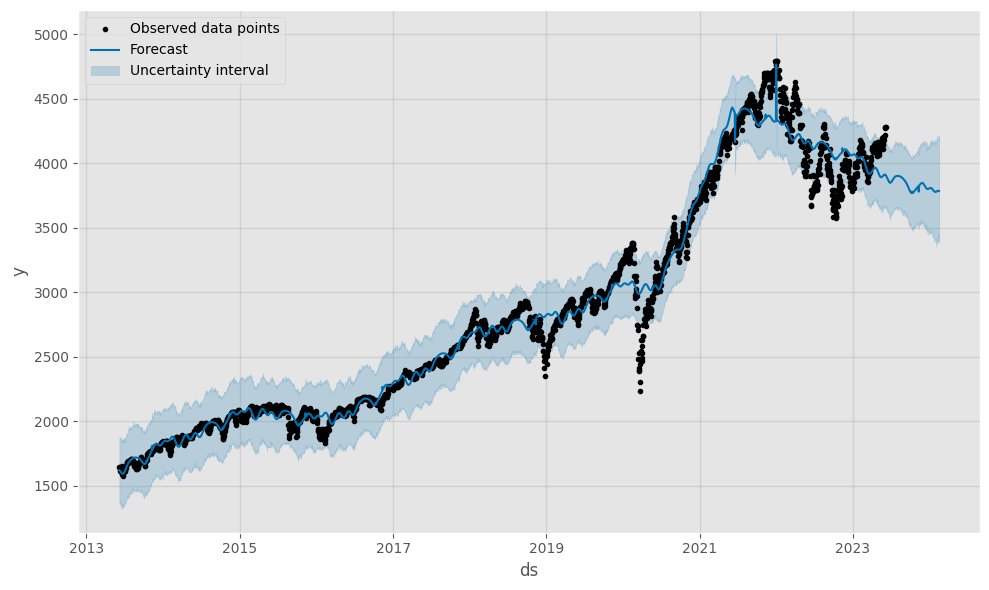

In [67]:
fig = model.plot(forecast)
plt.legend()

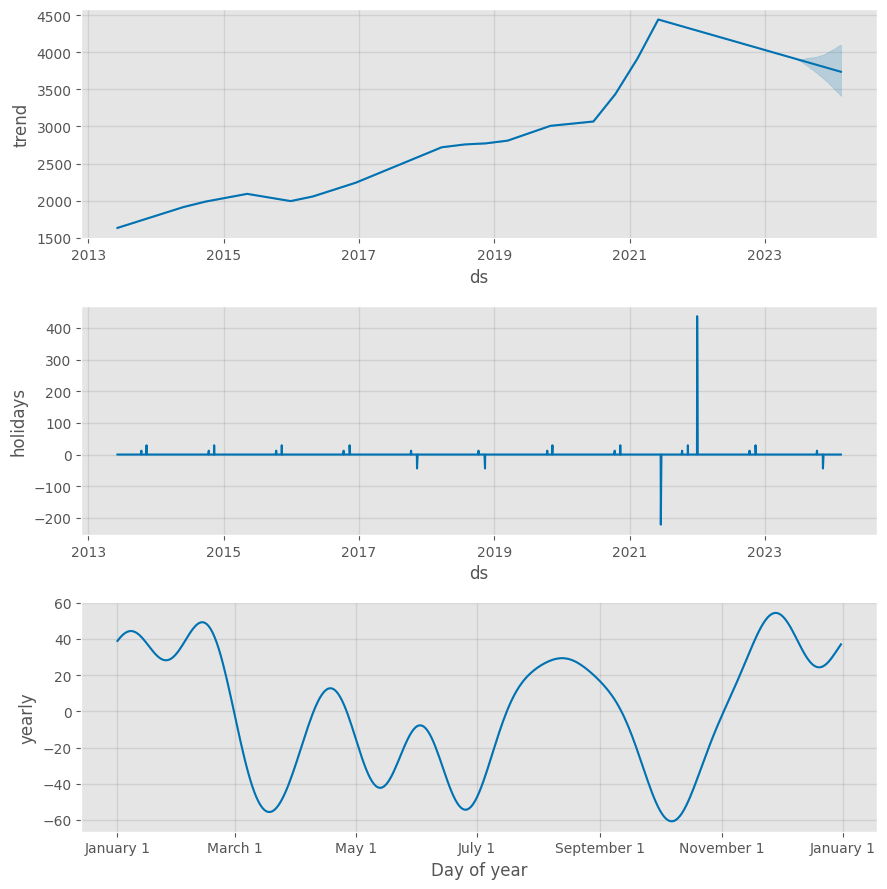

In [68]:
fig2 = model.plot_components(forecast)